<a href="https://colab.research.google.com/github/jdowner212/cs577_addernet/blob/main/AdderNet_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from data import load_cifar_data
from model import Model
import layers
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
root = os.getcwd()
data_dir = f'{root}/cifar-10-batches-py'
X_trn_c10, y_trn_c10, X_tst_c10, y_tst_c10, X_val_c10, y_val_c10 = load_cifar_data(data_dir,tiny=True)

In [3]:
this_model = Model(loss_name='cat_cross_entropy')

this_model.add(layers.adder_layer(output_channels=8,kernel_size=3,stride=1,padding=1,adaptive_eta=0.1))
this_model.add(layers.Activation('relu'))
this_model.add(layers.MaxPool(pool_size=2))
this_model.add(layers.batch_norm_layer())


this_model.add(layers.Flatten())
this_model.add(layers.FullyConnected(output_channels=64))
this_model.add(layers.Activation('relu'))
this_model.add(layers.FullyConnected(output_channels=10))
this_model.add(layers.Activation('softmax'))

In [28]:
history, summaries = this_model.fit(X_trn_c10,y_trn_c10,epochs=20,batch_size=16,learning_rate=1e-03,x_val=X_val_c10,y_val=y_val_c10)

0
Epoch: 0   loss = 0.0   acc = 0.0   val_loss = 13.838   val_accuracy = 0.03
1
Epoch: 1   loss = 0.0   acc = 0.0   val_loss = 13.468   val_accuracy = 0.03
2
Epoch: 2   loss = 0.0   acc = 0.0   val_loss = 13.806   val_accuracy = 0.03
3
Epoch: 3   loss = 0.0   acc = 0.0   val_loss = 13.701   val_accuracy = 0.03
4
Epoch: 4   loss = 0.0   acc = 0.0   val_loss = 13.49   val_accuracy = 0.03
5
Epoch: 5   loss = 0.0   acc = 0.0   val_loss = 14.525   val_accuracy = 0.03
6
Epoch: 6   loss = 0.0   acc = 0.0   val_loss = 13.674   val_accuracy = 0.03
7
Epoch: 7   loss = 0.0   acc = 0.0   val_loss = 13.613   val_accuracy = 0.03
8


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(20),history['accuracy'],label='train')
plt.plot(range(20),history['val_accuracy'],label='val')
plt.legend()
plt.xlabel('Epochs')
plt.xticks(range(0,21,2))
plt.ylim(0,0.3)
plt.title('Accuracy -- our AdderNet implementation')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(20),history['loss'],label='train')
plt.plot(range(20),history['val_loss'],label='val')
plt.legend()
plt.xlabel('Epochs')
plt.xticks(range(0,21,2))
plt.ylim(0,0.1)
plt.title('Loss -- our AdderNet implementation')
plt.show()



In [8]:
data = [x[1] for x in summaries[0]]
labels = [x[0] for x in summaries[0]]

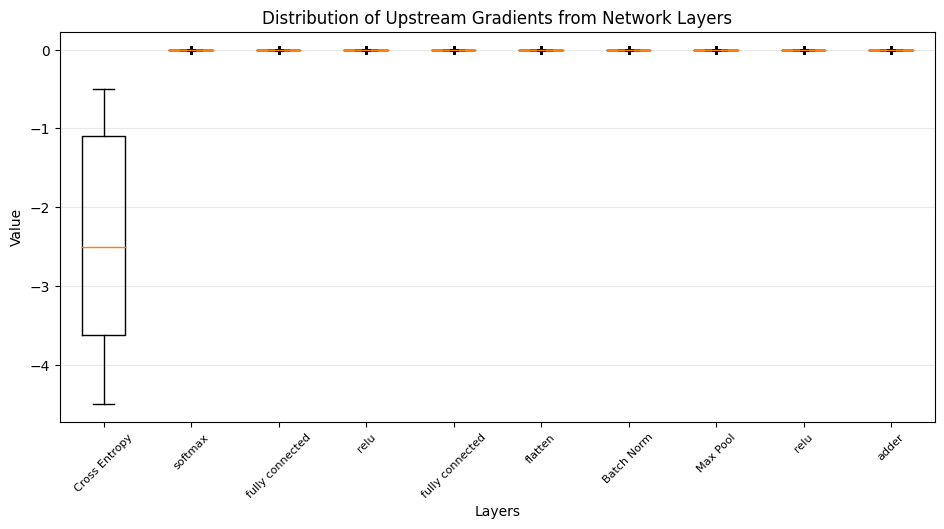

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.manager.set_window_title('Layer Gradients')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=False, sym='+', vert=True, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')


ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True, 
    title='Distribution of Upstream Gradients from Network Layers',
    xlabel='Layers',
    ylabel='Value',
)

ax1.set_xticklabels(labels,
                    rotation=45, fontsize=8)


plt.show()

In [ ]:
cnn = Model(loss_name='cat_cross_entropy')

cnn.add(layers.conv_layer(output_channels=8,kernel_size=3,stride=1,padding=1))
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool(pool_size=2))
cnn.add(layers.batch_norm_layer())
cnn.add(layers.Flatten())
cnn.add(layers.FullyConnected(output_channels=64))
cnn.add(layers.batch_norm_layer())
cnn.add(layers.Activation('relu'))
cnn.add(layers.FullyConnected(output_channels=10))
cnn.add(layers.batch_norm_layer())
cnn.add(layers.Activation('softmax'))

NameError: ignored

In [ ]:
cnn.fit(X_trn_c10,y_trn_c10,10,1e-05,X_val_c10,y_val_c10)

0
0


ValueError: ignored

In [ ]:
def add2d(X, K):  
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] + K))
    return Y


class adder_2d(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, kernel_size):
        initializer = tf.random_normal_initializer()
        self.weight = self.add_weight(name='w', shape=kernel_size,
                                      initializer=initializer)
        self.bias = self.add_weight(name='b', shape=(1, ),
                                    initializer=initializer)

    def call(self, inputs):
        return add2d(inputs, self.weight) + self.bias


class add_it(tf.keras.layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )